### 네이버 데이터랩의 검색어 트렌드의 주가 영향력 분석
* 검색어 트렌드 분석을 통한 검색어 증가에 따른 주가 영향 분석
* 마케팅 효과에따른 검색어 증가량 분석
* 마케팅 수명관리
* 경쟁사 마케팅 파급효과 분석


In [2]:
nid = '5VYByIqqUT2Jo4zTjk8I'
nkey = '8bf81LdFVe'

In [3]:

import json ###########################
import os
import sys
import urllib.request


In [4]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fname=fm.FontProperties(fname='malgun.ttf').get_name()
mpl.rc('font',family=fname)
import matplotlib.gridspec as gridspec


In [5]:
def makeQry(keywords=[],sday='2019-01-01',eday='2020-08-30',tunit='date'):
    res=[]
    for words in keywords:
        dict={'groupName':words[0],'keywords':words}
        res.append(dict)
    rdict={"startDate":sday,
    "endDate":eday,
    "timeUnit":tunit,
    "keywordGroups":res
          }
    return json.dumps(rdict,ensure_ascii = False )


In [6]:
def Mynsearch(keywords=[],sday='2019-01-01',eday='2020-08-30',tunit='month'):    
    client_id = nid ##########################
    client_secret = nkey ###########################
    url = "https://openapi.naver.com/v1/datalab/search";
    
    body=makeQry(keywords,sday,eday,tunit)
    
    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-Id",client_id)
    request.add_header("X-Naver-Client-Secret",client_secret)
    request.add_header("Content-Type","application/json")
    response = urllib.request.urlopen(request, data=body.encode("utf-8"))
    rescode = response.getcode()
    if(rescode==200):
        response_body = response.read()
        res=response_body.decode('utf-8')
        #print(res)
    else:
        res="error"
        print("Error Code:" + rescode)
    return res

In [7]:

def MyDataLab(keywords=[],sday='2019-01-01',eday='2020-08-30',tunit='month'):
    # 네이버 데이터랩 서치
    res=Mynsearch(keywords,sday,eday,tunit)
    #데이터 추출을 위한 json
    #print(res)
    jdata=json.loads(res)
            #print(len(jdata['results']))
    i=0;
    #테이블 머지를 위한 기초테이블
    maindf=pd.DataFrame()
    # 키워드별로 컬럼명 지정
    for words in keywords:
        pdata=jdata['results'][i]['data']
        i+=1
        df=pd.DataFrame.from_dict(pdata)
        df.columns=["period",words[0].strip()]
        df1=df.set_index("period")
        maindf=pd.merge(maindf,df1,how="outer",left_index=True,right_index=True)
    return maindf


               극한직업      사바하      걸캅스    나쁜녀석들      백두산
period                                                 
2019-01-01  0.51273  0.03758  0.01178  0.15669  0.14547
2019-01-02  0.59014  0.03655  0.01355  0.14220  0.11658
2019-01-03  0.57528  0.02870  0.00981  0.11350  0.10892
2019-01-04  5.09767  0.02758  0.01552  0.12453  0.10172
2019-01-05  1.13232  0.03300  0.01299  0.14248  0.08695


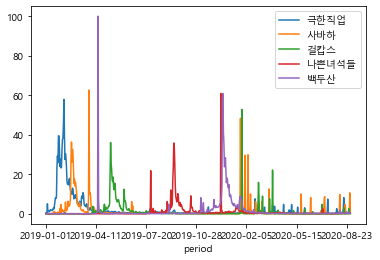

In [8]:
keywords=[
['극한직업'],
['사바하'],
['걸캅스'],
['나쁜녀석들'],
['백두산'],
#['기생충','봉준호','짜파구리'],
]
mdf=MyDataLab(keywords,'2019-01-01','2020-08-30','date')
print(mdf.head())
mdf.plot()
plt.show()

In [9]:
import sqlite3
dbname='C:/Users/이상은/Desktop/NaverStock.db'
def selData(whr=' where SIDX=0'):
    with sqlite3.connect(dbname) as conn:
        cur=conn.cursor()
        sql='select SDAY,OPENP,HIGHP,LOWP,CLOSEP,VOL from StockDay '+whr
        cur.execute(sql)
        rows=cur.fetchall()
        cur.close()
    return rows

In [10]:
def MyDBLab(keywords=[],sday='2019-01-01',eday='2020-08-30',tunit='month',scode='035760'):
    mdf=MyDataLab(keywords,sday,eday,tunit)
    sdaycode=sday.replace('-','')
    edaycode=eday.replace('-','')
    whsrc='where SDAY>={0} and SDAY<={1} and SCODE="{2}" order by SDAY  asc'
    whr=whsrc.format(sdaycode,edaycode,scode)
    res=selData(whr)
    cols=['SDAY','OPENP','HIGHP','LOWP','CLOSEP','VOL']
    dfsrc=pd.DataFrame(data=res,columns=cols)
    dfsrc['period']=[str(p)[:4]+"-"+str(p)[4:-2]+"-"+str(p)[-2:] for p in dfsrc['SDAY']]
    dfstock=dfsrc.set_index('period')
    df=pd.merge(dfstock,mdf,how="outer",left_index=True, right_index=True)
    alldf=df.interpolate() ############# 선형보간
    return alldf

In [11]:
keywords=[
['극한직업'],
['사바하'],
['걸캅스'],
['나쁜녀석들'],
['백두산'],
# ['기생충','봉준호','짜파구리'],
]
alldf=MyDBLab(keywords,'2019-01-15','2019-02-15','date','035760')
alldf.head(10)

,SDAY,OPENP,HIGHP,LOWP,CLOSEP,VOL,극한직업,사바하,걸캅스,나쁜녀석들,백두산
period,,,,,,,,,,,
2019-01-15,20190115.0,211400.000000,212900.000000,208400.0,212900.0,54176.000000,4.04935,0.63167,0.01807,0.24299,0.24347
2019-01-16,20190116.0,213000.000000,217600.000000,211200.0,216000.0,82763.000000,5.14039,0.79915,0.01726,0.22056,0.23234
2019-01-17,20190117.0,214800.000000,215300.000000,205800.0,209100.0,66824.000000,4.38706,2.01185,0.03711,0.21427,0.18619
2019-01-18,20190118.0,208500.000000,208500.000000,202500.0,206500.0,74195.000000,7.29230,2.07122,0.01968,0.22120,0.17054
2019-01-19,20190119.0,207633.333333,208366.666667,203100.0,206200.0,66475.333333,10.99330,1.46827,0.01774,0.25751,0.16973
2019-01-20,20190120.0,206766.666667,208233.333333,203700.0,205900.0,58755.666667,14.18881,1.20624,0.01565,0.25396,0.16360
2019-01-21,20190121.0,205900.000000,208100.000000,204300.0,205600.0,51036.000000,13.45806,0.96437,0.02162,0.25138,0.15876
2019-01-22,20190122.0,205500.000000,206100.000000,203500.0,206000.0,33588.000000,15.23499,0.74397,0.01726,0.21765,0.17441
2019-01-23,20190123.0,205500.000000,205900.000000,203400.0,205800.0,48354.000000,40.86066,0.58633,0.02145,0.22717,0.22717


In [12]:
def PltDBLab(alldf,keywords,ptitle="CJ ENM 영화와 주가의 상관도",xstep=10,axvpos=10):
    xtic=np.arange(0,len(alldf.index),step=xstep)
    xdays=[alldf.index[i] for i in xtic]
    if(len(keywords)==1):
        setdf=alldf[keywords[0]]#,'사바하','걸캅스','나쁜녀석들','백두산'
    else:
        keys=[k[0] for k in keywords]
        setdf=alldf[keys]#,'사바하','걸캅스','나쁜녀석들','백두산'
    
    #setdf.head()
    font = {'family': fname,
            'color':  'aqua',
            'weight': 'normal',
            'size': 20,
            }
    # x 축을 공유하고 y축을 2중 사용
    plt.rcParams["figure.figsize"]=(12,6)
    fig, ax1=plt.subplots()
    plt.xticks(xtic,xdays,rotation=45)

    ax1.plot(alldf['CLOSEP'] ,color='orange')
    ax1.set_ylabel("Price")
    ax2=ax1.twinx()
    ax2.set_ylabel("Ratio")
    setdf.plot(ax=ax2)
    pos=axvpos
    plt.axvline(pos,color='aquamarine',linestyle="--")
    plt.text(pos,20,"개봉",fontdict=font)
    plt.title(ptitle)
    plt.legend()
    fig.tight_layout()
    plt.show()

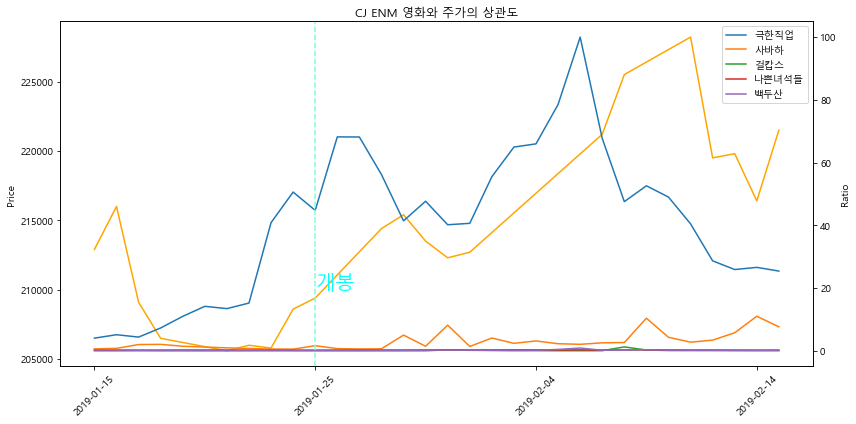

In [13]:
PltDBLab(alldf,keywords)

legend 설명 
* x축: 날짜 
* 왼 y축: price 주가 
* 오 y축: 검색률 

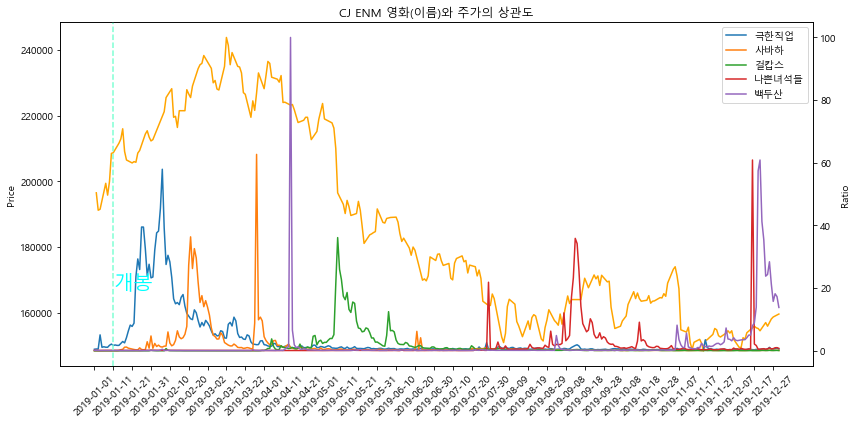

In [14]:
keywords=[
['극한직업'],
['사바하'],
['걸캅스'],
['나쁜녀석들'],
['백두산'],
#['기생충','봉준호','짜파구리'],
]
#MyDBLab(keywords)
alldf=MyDBLab(keywords,'2019-01-01','2019-12-30','date','035760')
#alldf.head()
PltDBLab(alldf,keywords,ptitle="CJ ENM 영화(이름)와 주가의 상관도",xstep=10)

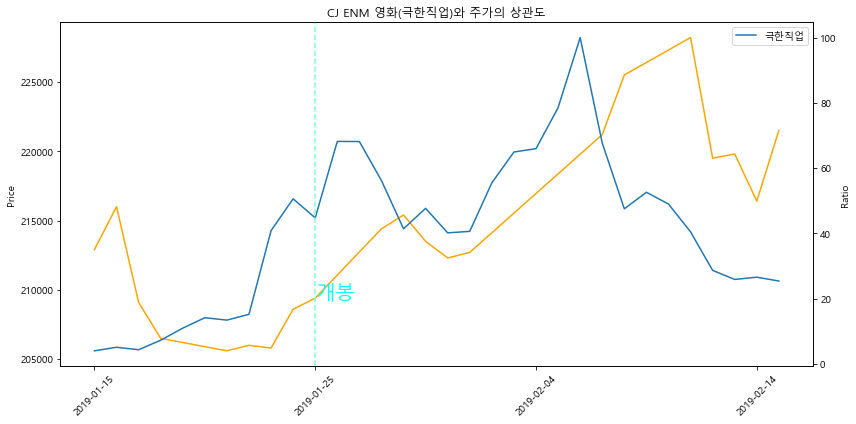

In [15]:
# 오렌지색은 CJ ENM 주가
keywords=[
['극한직업'],
#['사바하'],
#['걸캅스'],
#['나쁜녀석들'],
#['백두산'],
#['기생충','봉준호','짜파구리'],
]
#MyDBLab(keywords)
alldf=MyDBLab(keywords,'2019-01-15','2019-02-15','date','035760')
#alldf.head()
PltDBLab(alldf,keywords,"CJ ENM 영화(극한직업)와 주가의 상관도",xstep=10)

In [16]:
checkdf=alldf[['CLOSEP','극한직업']]
checkdf.corr()

,CLOSEP,극한직업
CLOSEP,1.000000,0.390641
극한직업,0.390641,1.000000


In [17]:
#필요없는 '0'데이터를 시각화에서 제외하기 위해 start일로부터 5일 이후를 시각화 
checkdf.columns=['CLOSEP','극한직업_shift']
shiftdf=checkdf['극한직업_shift'].shift(5,fill_value=0)
shiftdf.sample(10)

period
2019-02-06    40.64413
2019-01-29    50.60997
2019-02-12    67.69305
2019-01-17     0.00000
2019-02-14    52.61118
2019-01-28    40.86066
2019-01-21     5.14039
2019-02-03    41.43248
2019-02-13    47.55323
2019-01-20     4.04935
Name: 극한직업_shift, dtype: float64

In [30]:
alldf.head()

,SDAY,OPENP,HIGHP,LOWP,CLOSEP,VOL,백두산
period,,,,,,,
2019-12-19,20191219.0,155400.000000,156000.0,154000.000000,155200.000000,46647.000000,94.28450
2019-12-20,20191220.0,155800.000000,156700.0,154500.000000,154500.000000,65147.000000,100.00000
2019-12-21,20191221.0,155533.333333,157000.0,154666.666667,155333.333333,64117.666667,67.80362
2019-12-22,20191222.0,155266.666667,157300.0,154833.333333,156166.666667,63088.333333,58.21080
2019-12-23,20191223.0,155000.000000,157600.0,155000.000000,157000.000000,62059.000000,39.14325


In [19]:
shiftall=pd.merge(alldf,shiftdf,how="inner",left_index=True,right_index=True)
shiftall.head(10)

,SDAY,OPENP,HIGHP,LOWP,CLOSEP,VOL,극한직업,극한직업_shift
period,,,,,,,,
2019-01-15,20190115.0,211400.000000,212900.000000,208400.0,212900.0,54176.000000,4.04935,0.00000
2019-01-16,20190116.0,213000.000000,217600.000000,211200.0,216000.0,82763.000000,5.14039,0.00000
2019-01-17,20190117.0,214800.000000,215300.000000,205800.0,209100.0,66824.000000,4.38706,0.00000
2019-01-18,20190118.0,208500.000000,208500.000000,202500.0,206500.0,74195.000000,7.29230,0.00000
2019-01-19,20190119.0,207633.333333,208366.666667,203100.0,206200.0,66475.333333,10.99330,0.00000
2019-01-20,20190120.0,206766.666667,208233.333333,203700.0,205900.0,58755.666667,14.18881,4.04935
2019-01-21,20190121.0,205900.000000,208100.000000,204300.0,205600.0,51036.000000,13.45806,5.14039
2019-01-22,20190122.0,205500.000000,206100.000000,203500.0,206000.0,33588.000000,15.23499,4.38706
2019-01-23,20190123.0,205500.000000,205900.000000,203400.0,205800.0,48354.000000,40.86066,7.29230


In [20]:
check5=shiftall[['CLOSEP','극한직업_shift']]
check5.corr()

,CLOSEP,극한직업_shift
CLOSEP,1.00000,0.81211
극한직업_shift,0.81211,1.00000


In [21]:
def shiftGraph(shiftall,baseCol,ptitle='shift 결과',axvpos=10,textpos=20,xstep=10):
    font = {'family': fname,
            'color':  'aqua',
            'weight': 'normal',
            'size': 20,
            }
    xtic=np.arange(0,len(shiftall.index),step=10)
    xdays=[shiftall.index[i] for i in xtic]
    sdf=shiftall[baseCol+'_shift']#,'사바하','걸캅스','나쁜녀석들','백두산'
    plt.rcParams["figure.figsize"]=(12,6)
    fig, ax1=plt.subplots()
    plt.xticks(xtic,xdays,rotation=45)
    ax1.plot(shiftall['CLOSEP'] ,color='gold')
    ax1.set_ylabel("Price")
    ax2=ax1.twinx()
    ax2.set_ylabel("Ratio")
    sdf.plot(ax=ax2)
    plt.axvline(axvpos,color='aquamarine',linestyle="--")
    plt.text(axvpos,textpos,"개봉",fontdict=font)
    plt.title(ptitle)
    plt.legend()
    fig.tight_layout()
    plt.show()

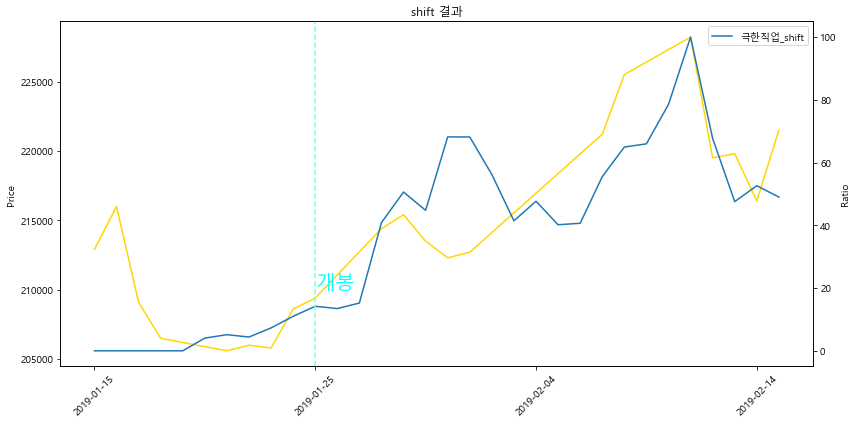

In [22]:
shiftGraph(shiftall,'극한직업')

### 통계량 분석
#### 피어슨 상관계수
* 피어슨 상관 계수(Pearson Correlation Coefficient ,PCC)
* 두 변수 X 와 Y 간의 선형 상관 관계를 계량화한 수치
* 피어슨 상관 계수는 코시-슈바르츠 부등식에 의해 +1과 -1 사이의 값을 가짐
* +1은 완벽한 양의 선형 상관 관계
* 0은 선형 상관 관계 없음
* -1은 완벽한 음의 선형 상관 관계

In [23]:
     
def shiftLab(alldf,baseCol='극한직업',shiftday=5):
    # 기존 정보상의 상관분석 - 효과 적음
    checkdf=alldf[['CLOSEP',baseCol]]
    print("*"*40)
    print(checkdf.describe())
    print("*"*40)
    print(checkdf.corr())

    # 쉬프트 정보 작성
    checkdf.columns=['CLOSEP',baseCol+'_shift']
    shiftdf=checkdf[''+baseCol+'_shift'].shift(shiftday,fill_value=0)
    # 기존 데이터와 병합 작성
    shiftall=pd.merge(alldf,shiftdf,how="inner",left_index=True,right_index=True)
    check5=shiftall[['CLOSEP',baseCol+'_shift']]
    # 새로운 상관분석
    print("*"*40)
    print(check5.corr())
    print("*"*40)

    shiftGraph(shiftall,baseCol)

****************************************
              CLOSEP        극한직업
count      32.000000   32.000000
mean   214832.812500   40.700198
std      6635.355887   24.167937
min    205600.000000    4.049350
25%    209325.000000   22.878787
50%    214258.333333   41.146570
75%    219570.833333   55.676147
max    228200.000000  100.000000
****************************************
          CLOSEP      극한직업
CLOSEP  1.000000  0.390641
극한직업    0.390641  1.000000
****************************************
             CLOSEP  극한직업_shift
CLOSEP      1.00000     0.81211
극한직업_shift  0.81211     1.00000
****************************************


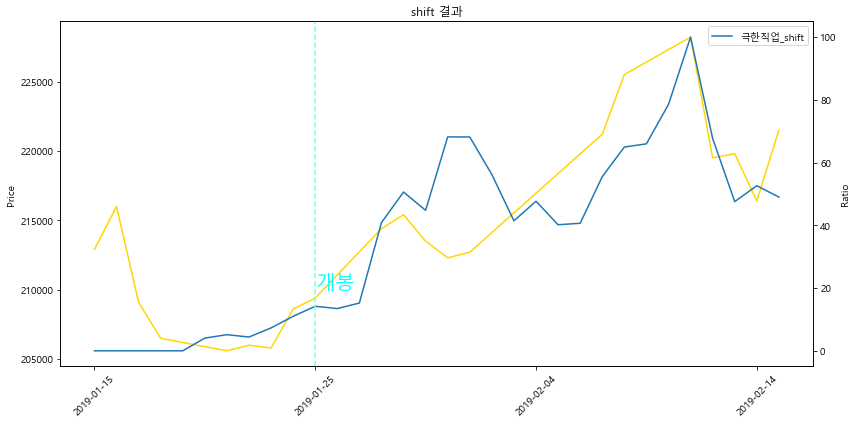

In [24]:
shiftLab(alldf,'극한직업',5)

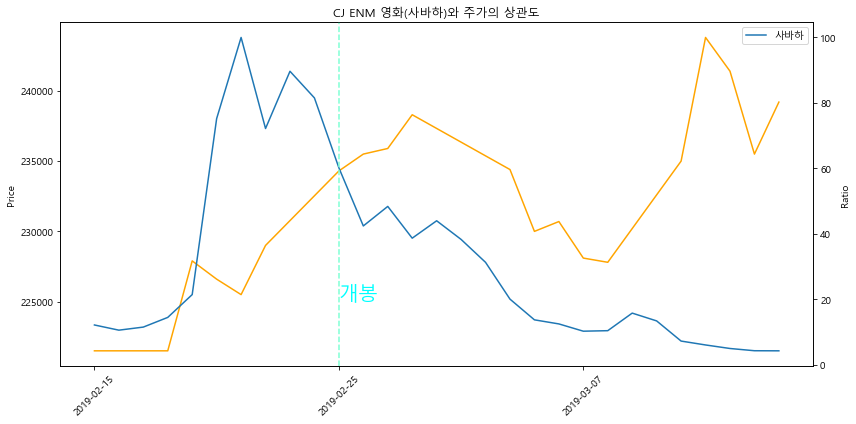

****************************************
              CLOSEP         사바하
count      29.000000   29.000000
mean   231725.862069   31.584496
std      6028.340535   28.601482
min    221500.000000    4.310830
25%    227900.000000   10.618500
50%    232533.333333   15.825840
75%    235500.000000   44.022350
max    243800.000000  100.000000
****************************************
          CLOSEP       사바하
CLOSEP  1.000000 -0.078005
사바하    -0.078005  1.000000
****************************************
             CLOSEP  사바하_shift
CLOSEP     1.000000   0.473025
사바하_shift  0.473025   1.000000
****************************************


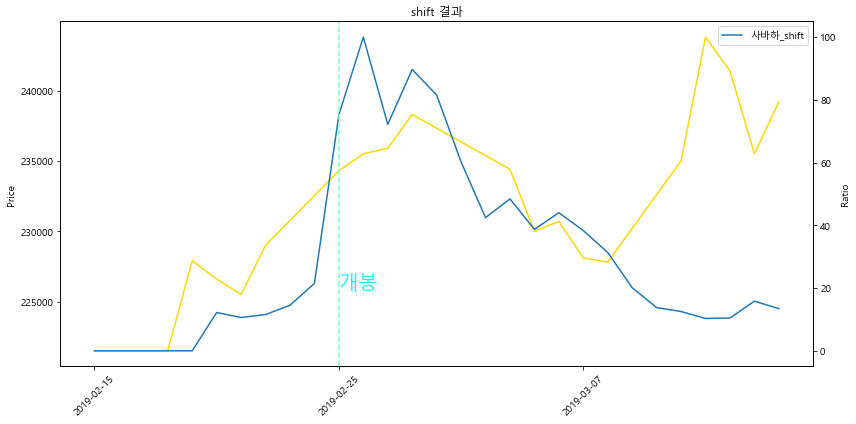

In [25]:
keywords=[
#['극한직업'],
['사바하'],
#['걸캅스'],
#['나쁜녀석들'],
#['백두산'],
#['기생충','봉준호','짜파구리'],
]
alldf=MyDBLab(keywords,'2019-02-15','2019-03-15','date','035760')
#alldf.head()
PltDBLab(alldf,keywords,"CJ ENM 영화(사바하)와 주가의 상관도",xstep=10)
shiftLab(alldf,'사바하',5)

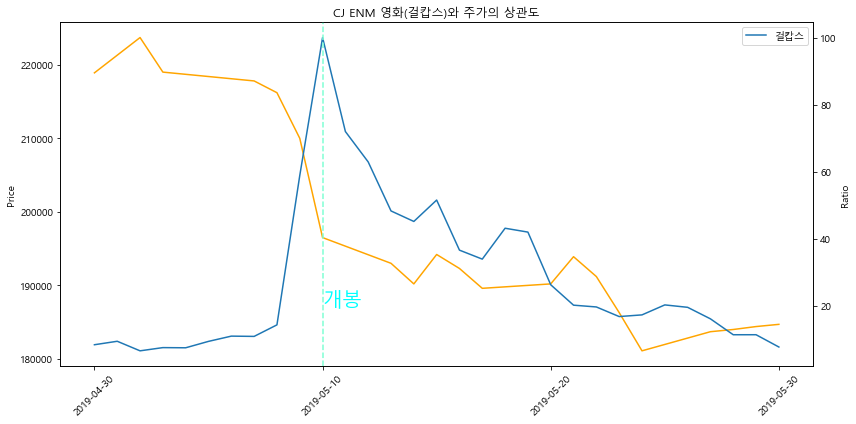

****************************************
              CLOSEP         걸캅스
count      31.000000   31.000000
mean   198435.483871   27.915010
std     14543.844149   22.981514
min    181100.000000    6.552710
25%    187950.000000   10.895965
50%    193000.000000   19.531630
75%    217000.000000   42.542740
max    223700.000000  100.000000
****************************************
          CLOSEP       걸캅스
CLOSEP  1.000000 -0.263372
걸캅스    -0.263372  1.000000
****************************************
             CLOSEP  걸캅스_shift
CLOSEP     1.000000  -0.560901
걸캅스_shift -0.560901   1.000000
****************************************


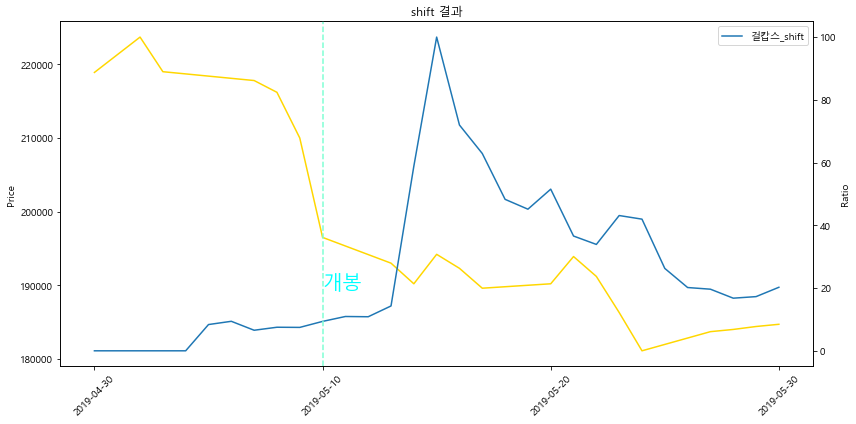

In [26]:
keywords=[
#'극한직업'],
#'사바하'],
['걸캅스'],
#['나쁜녀석들'],
#['백두산'],
#['기생충','봉준호','짜파구리'],
]
alldf=MyDBLab(keywords,'2019-04-30','2019-05-30','date','035760')
#alldf.head()
PltDBLab(alldf,keywords,"CJ ENM 영화(걸캅스)와 주가의 상관도",xstep=10)
shiftLab(alldf,'걸캅스',5)

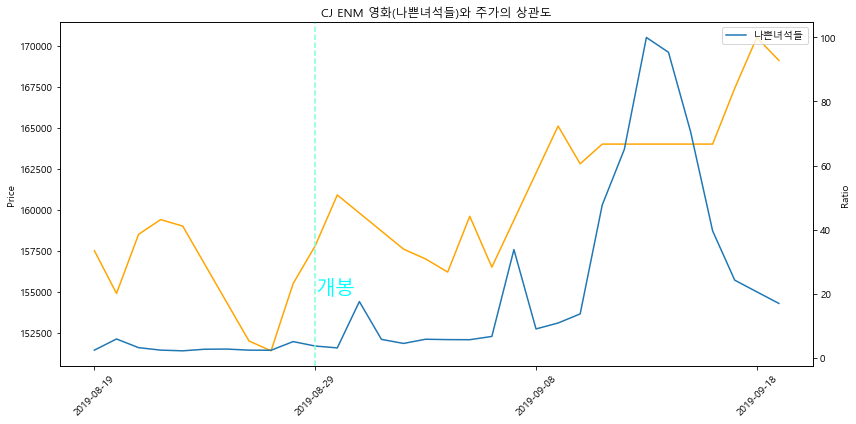

****************************************
              CLOSEP       나쁜녀석들
count      32.000000   32.000000
mean   160118.750000   19.862826
std      4645.149607   27.220238
min    151400.000000    2.122240
25%    156916.666667    3.093680
50%    159383.333333    5.779125
75%    164000.000000   21.461133
max    170500.000000  100.000000
****************************************
          CLOSEP     나쁜녀석들
CLOSEP  1.000000  0.515131
나쁜녀석들   0.515131  1.000000
****************************************
              CLOSEP  나쁜녀석들_shift
CLOSEP       1.00000      0.72544
나쁜녀석들_shift  0.72544      1.00000
****************************************


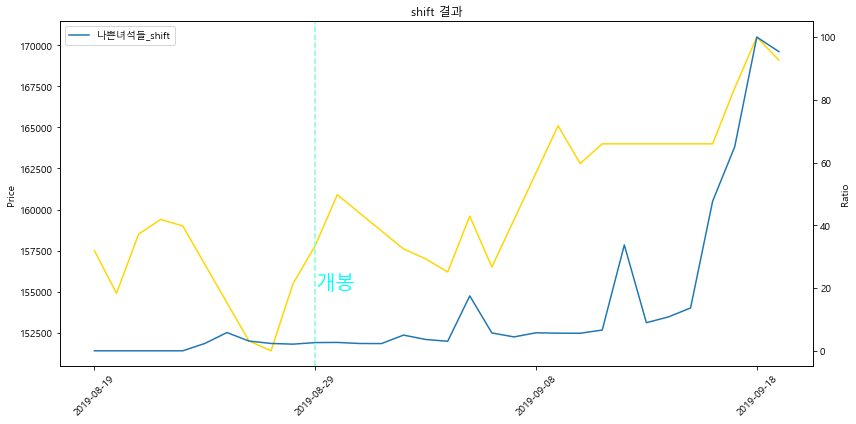

In [27]:
keywords=[
#'극한직업'],
#'사바하'],
#['걸캅스'],
['나쁜녀석들'],
#['백두산'],
#['기생충','봉준호','짜파구리'],
]
alldf=MyDBLab(keywords,'2019-08-19','2019-09-19','date','035760')
#alldf.head()
PltDBLab(alldf,keywords,"CJ ENM 영화(나쁜녀석들)와 주가의 상관도",xstep=10)
shiftLab(alldf,'나쁜녀석들',5)

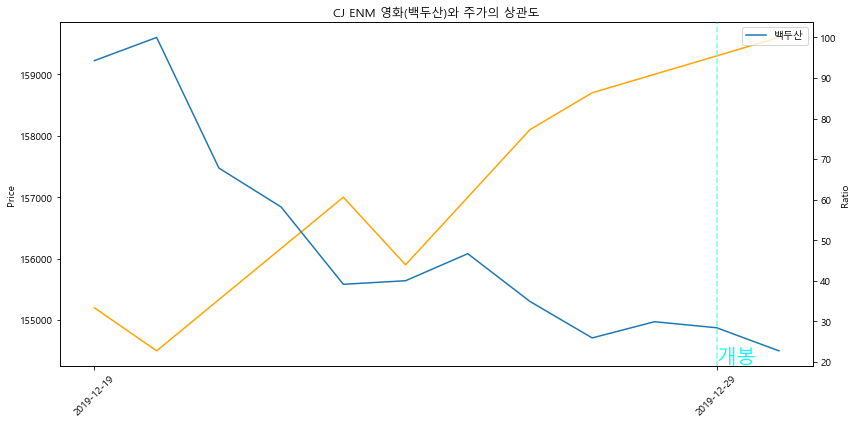

****************************************
              CLOSEP         백두산
count      12.000000   12.000000
mean   157150.000000   49.003385
std      1759.447801   26.080540
min    154500.000000   22.738520
25%    155758.333333   29.540028
50%    157000.000000   39.579605
75%    158775.000000   60.609005
max    159600.000000  100.000000
****************************************
         CLOSEP      백두산
CLOSEP  1.00000 -0.88492
백두산    -0.88492  1.00000
****************************************
             CLOSEP  백두산_shift
CLOSEP     1.000000   0.404196
백두산_shift  0.404196   1.000000
****************************************


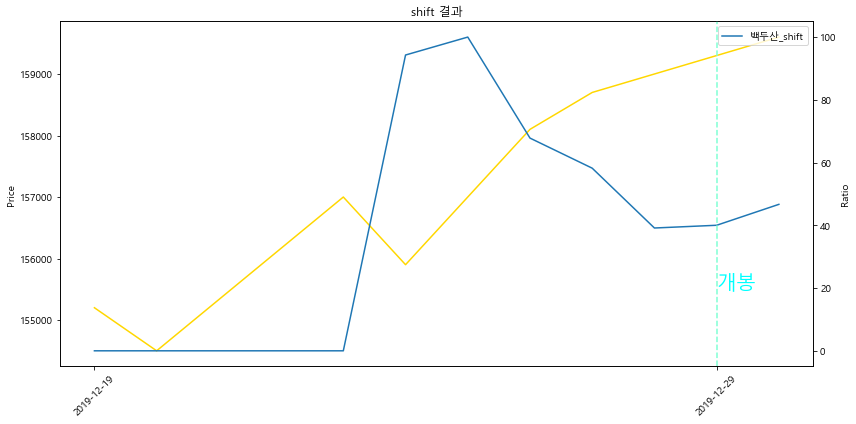

In [28]:
keywords=[
#'극한직업'],
#'사바하'],
#['걸캅스'],
#['나쁜녀석들'],
['백두산'],
#['기생충','봉준호','짜파구리'],
]
alldf=MyDBLab(keywords,'2019-12-19','2019-12-30','date','035760')
#alldf.head()
PltDBLab(alldf,keywords,"CJ ENM 영화(백두산)와 주가의 상관도",xstep=10)
shiftLab(alldf,'백두산',5)